In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, make_scorer
from scipy.stats import shapiro, ttest_rel, mannwhitneyu

In [2]:
serie = pd.read_csv("../data/unified_cluster_series_with_clipped3.csv", parse_dates=["end_timestamp"], index_col="end_timestamp")

In [ ]:
umbral = serie["volume"].quantile(0.90)
y = serie["volume"]
picks = (serie["volume"] > umbral).astype(int)

# Crear features sin incluir "volume" (para evitar data leakage)
X = pd.DataFrame(serie)
X = X.drop(columns=["volume"])  # ← IMPORTANTE: Eliminar el target de las features
X = X.dropna()
picks = picks.loc[X.index]
y = y.loc[X.index]

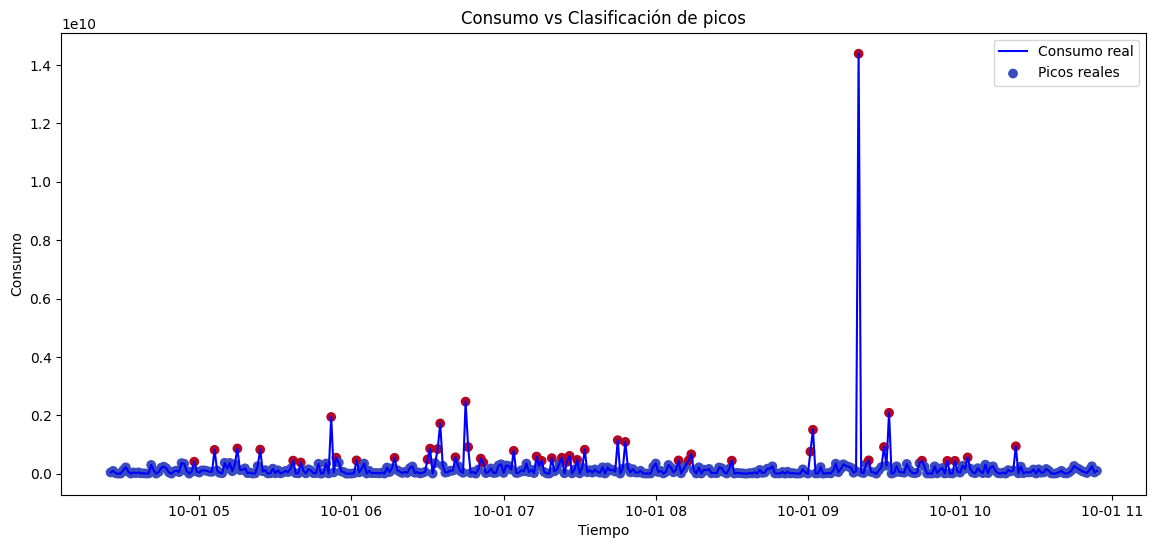

In [393]:
volume_aligned = serie.loc[X.index, "volume"]

plt.figure(figsize=(14,6))
plt.plot(X.index, volume_aligned, label="Consumo real", color="blue")
plt.scatter(X.index, volume_aligned, c=picks, cmap="coolwarm", label="Picos reales", marker="o")
plt.title("Consumo vs Clasificación de picos")
plt.xlabel("Tiempo")
plt.ylabel("Consumo")
plt.legend()
plt.show()

Se entrenarán modelos de predicción con el objetivo de escoger el mejor y en base a eso clasificar posibles picos (fijados por un umbral). Con este fin se hará uso del framework de automl que se dispone en este repositorio.

In [394]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [395]:
# Crear variables de clasificación alineadas con el split temporal
y_train_cls = y.loc[X_train.index]
y_test_cls = y.loc[X_test.index]

In [396]:
kf = TimeSeriesSplit(n_splits=30)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

rf = RandomForestRegressor(
    n_estimators=158, max_depth=10, min_samples_split=6,
    min_samples_leaf=1, max_features=None, random_state=42
)
knn = KNeighborsRegressor(n_neighbors=7, weights="uniform", p=2)

scores_rf = cross_val_score(rf, X_train, y_train, cv=kf, scoring=scorer)
scores_knn = cross_val_score(knn, X_train, y_train, cv=kf, scoring=scorer)

rf_mean, rf_std = -scores_rf.mean(), scores_rf.std()
knn_mean, knn_std = -scores_knn.mean(), scores_knn.std()

print("Random Forest MAE promedio:", rf_mean, "±", rf_std)
print("KNN MAE promedio:", knn_mean, "±", knn_std)

Random Forest MAE promedio: 328632338.47674644 ± 326070529.7540322
KNN MAE promedio: 226053592.13333336 ± 263157234.73491463


In [397]:
shapiro_rf = shapiro(scores_rf)
shapiro_knn = shapiro(scores_knn)
print(f"\nShapiro-Wilk RF p-value: {shapiro_rf.pvalue:.3f}")
print(f"Shapiro-Wilk KNN p-value: {shapiro_knn.pvalue:.3f}")


Shapiro-Wilk RF p-value: 0.000
Shapiro-Wilk KNN p-value: 0.000


In [398]:
if shapiro_rf.pvalue > 0.05 and shapiro_knn.pvalue > 0.05:
    stat, pval = ttest_rel(scores_rf, scores_knn)
    print(f"\nt-Student: statistic={stat:.3f}, p-value={pval:.3f}")
else:
    stat, pval = mannwhitneyu(scores_rf, scores_knn)
    print(f"\nMann-Whitney: statistic={stat:.3f}, p-value={pval:.3f}")


Mann-Whitney: statistic=314.000, p-value=0.045


In [399]:
if pval < 0.05:
    best_model = rf if rf_mean < knn_mean else knn
    best_name = "Random Forest" if rf_mean < knn_mean else "KNN"
else:
    best_model = knn
    best_name = "KNN (modelo más simple)"

print(f"\nModelo seleccionado: {best_name}")


Modelo seleccionado: KNN


In [400]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f"MAE en test: {test_mae:.3f}")

MAE en test: 134829596.956


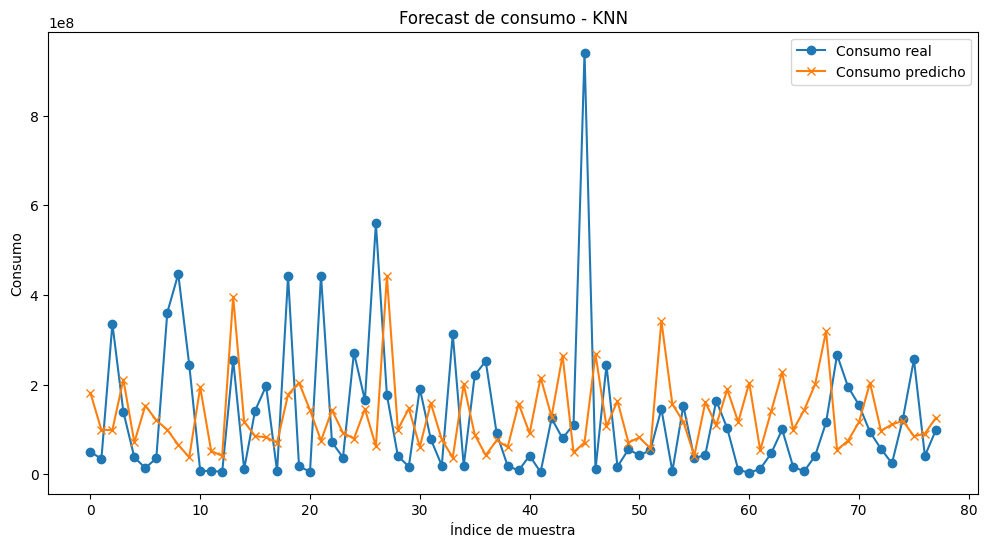

In [401]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Consumo real", marker="o")
plt.plot(y_pred, label="Consumo predicho", marker="x")
plt.title(f"Forecast de consumo - {best_name}")
plt.xlabel("Índice de muestra")
plt.ylabel("Consumo")
plt.legend()
plt.show()

=== REGRESIÓN + THRESHOLD: Predicción de Picos ===

Accuracy:  0.9103
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000


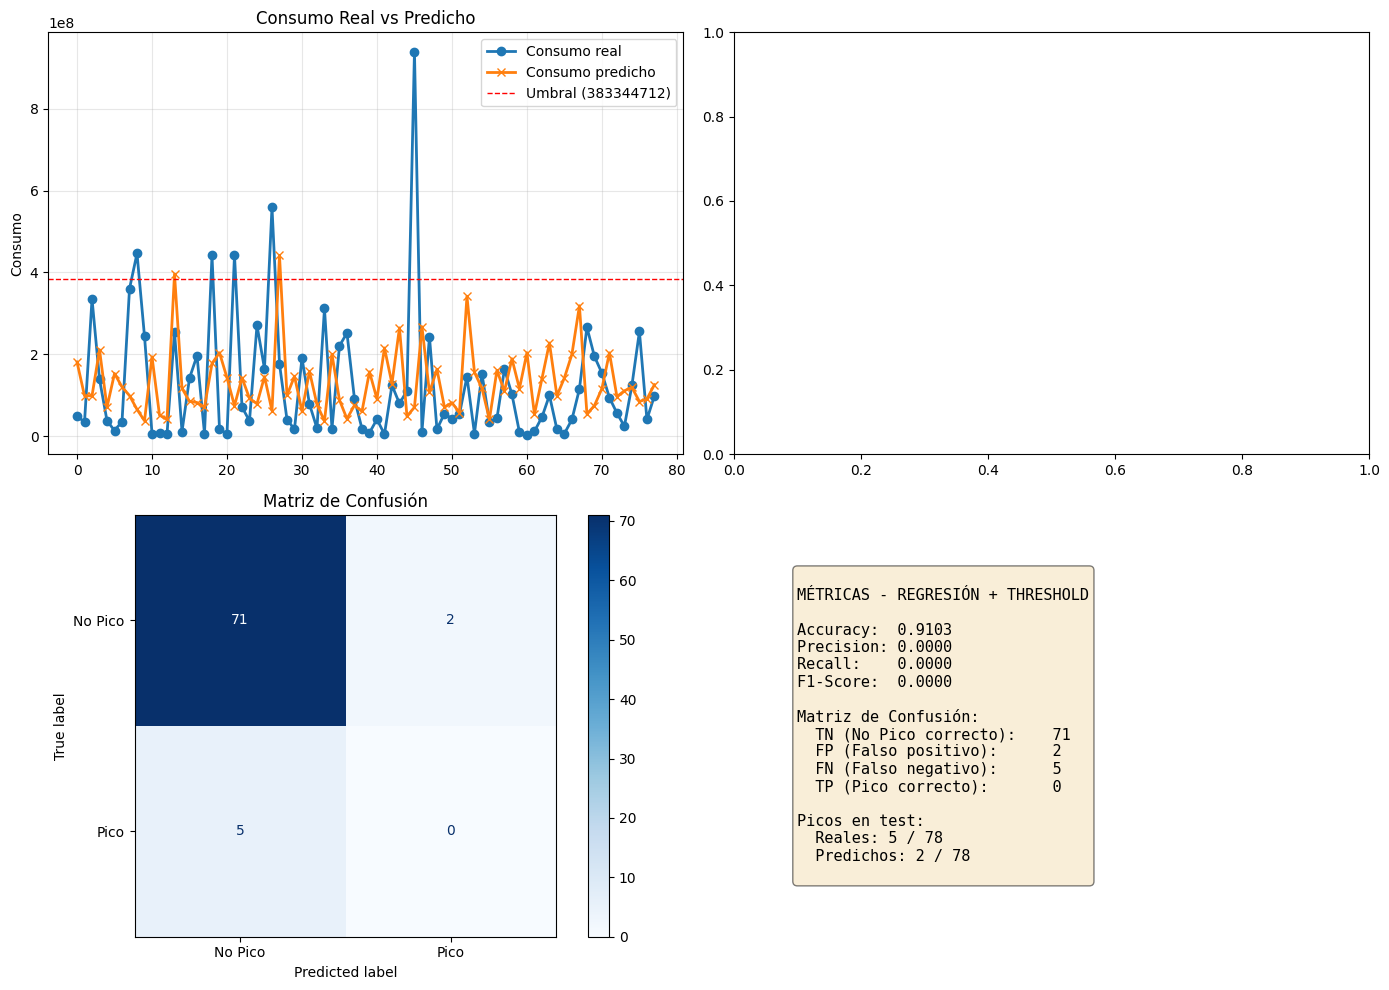

In [410]:
# Predicción de picos usando el mismo umbral (90-percentil)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Aplicar el mismo umbral al consumo predicho
picks_pred = (y_pred > umbral).astype(int)
picks_real = picks.loc[X_test.index]

# Calcular métricas
acc = accuracy_score(picks_real, picks_pred)
prec = precision_score(picks_real, picks_pred, zero_division=0)
rec = recall_score(picks_real, picks_pred, zero_division=0)
f1 = f1_score(picks_real, picks_pred, zero_division=0)

print("=== REGRESIÓN + THRESHOLD: Predicción de Picos ===\n")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Gráfico
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top: Consumo real vs predicho con picos
ax1 = axes[0, 0]
x_idx = np.arange(len(X_test))
ax1.plot(x_idx, y_test.values, label="Consumo real", marker="o", linewidth=2)
ax1.plot(x_idx, y_pred, label="Consumo predicho", marker="x", linewidth=2)
ax1.axhline(umbral, color="red", linestyle="--", linewidth=1, label=f"Umbral ({umbral:.0f})")
ax1.set_title("Consumo Real vs Predicho")
ax1.set_ylabel("Consumo")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom left: Matriz de confusión
cm = confusion_matrix(picks_real, picks_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Pico", "Pico"])
disp_cm.plot(ax=axes[1, 0], cmap='Blues', values_format='d')
axes[1, 0].set_title("Matriz de Confusión")

# Bottom right: Métricas
ax4 = axes[1, 1]
ax4.axis('off')
metrics_text = f"""
MÉTRICAS - REGRESIÓN + THRESHOLD

Accuracy:  {acc:.4f}
Precision: {prec:.4f}
Recall:    {rec:.4f}
F1-Score:  {f1:.4f}

Matriz de Confusión:
  TN (No Pico correcto):    {cm[0,0]}
  FP (Falso positivo):      {cm[0,1]}
  FN (Falso negativo):      {cm[1,0]}
  TP (Pico correcto):       {cm[1,1]}

Picos en test:
  Reales: {picks_real.sum()} / {len(picks_real)}
  Predichos: {picks_pred.sum()} / {len(picks_pred)}
"""
ax4.text(0.1, 0.5, metrics_text, fontsize=11, family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         verticalalignment='center')

plt.tight_layout()
plt.show()

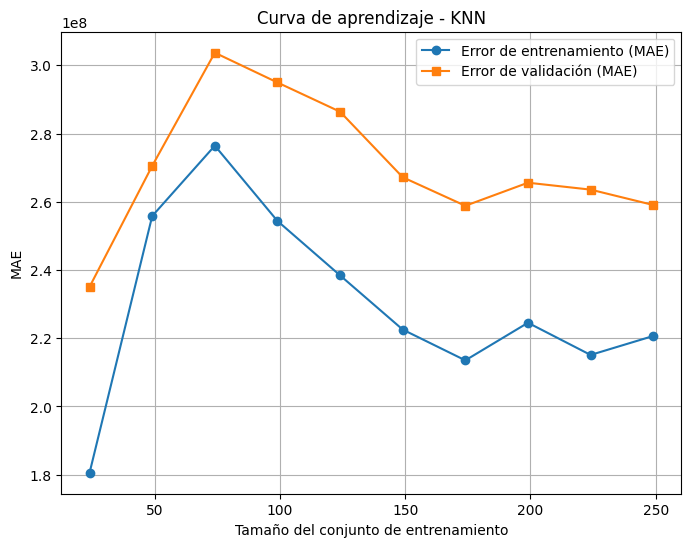

In [402]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    cv=5,
    scoring="neg_mean_absolute_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_mae = -train_scores.mean(axis=1)
val_mae = -val_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mae, label="Error de entrenamiento (MAE)", marker="o")
plt.plot(train_sizes, val_mae, label="Error de validación (MAE)", marker="s")
plt.title(f"Curva de aprendizaje - {best_name}")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

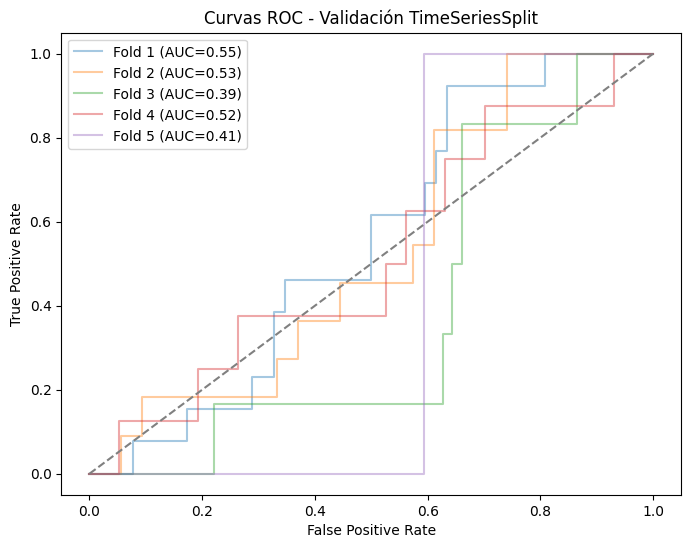

=== Resultados TimeSeriesSplit ===
F1 por fold: [0.18181818181818182, 0.25, 0.05405405405405406, 0.1875, 0.0]
Accuracy por fold: [0.5846153846153846, 0.5384615384615384, 0.46153846153846156, 0.6, 0.5384615384615384]
AUC por fold: [0.5517751479289941, 0.5286195286195287, 0.38700564971751417, 0.5175438596491229, 0.40625]
F1 promedio: 0.135
Accuracy promedio: 0.545
AUC promedio: 0.478


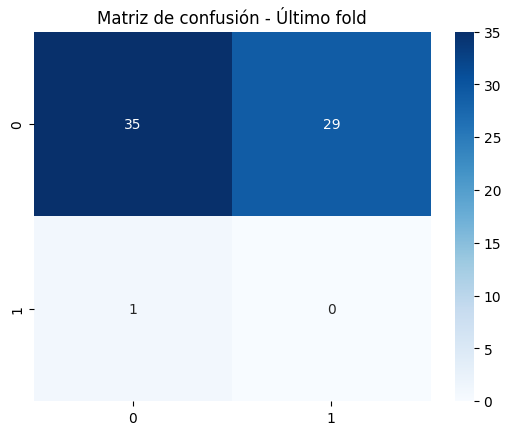

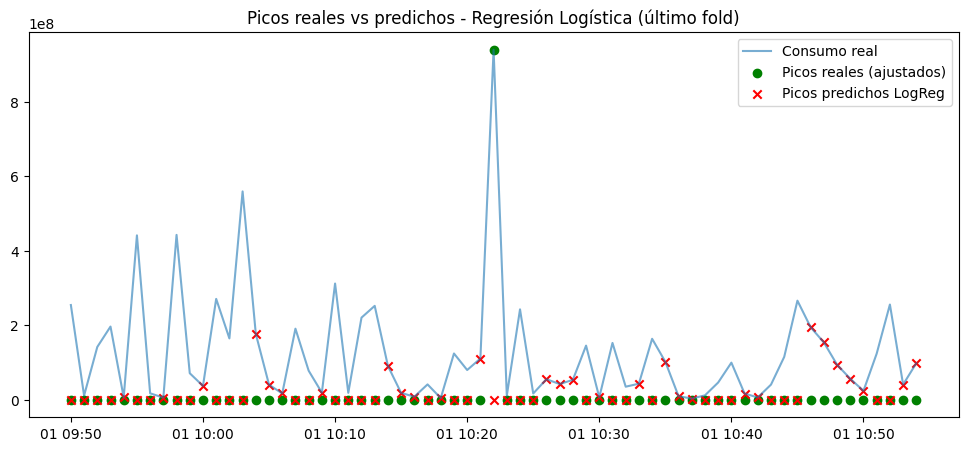

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, f1_score, accuracy_score

# =========================
# 1. Etiquetas supervisadas (pico futuro)
# =========================
serie = pd.read_csv("../data/unified_cluster_series_with_clipped3.csv",
                    parse_dates=["end_timestamp"], index_col="end_timestamp")

umbral = serie["volume"].quantile(0.90)
horizonte = 20  # minutos de anticipación
serie["pico_futuro"] = (serie["volume"].shift(-horizonte) > umbral).astype(int)

# =========================
# 2. Features históricos
# =========================
for lag in range(1, 4):
    serie[f"lag_{lag}"] = serie["volume"].shift(lag)

serie["rolling_mean3"] = serie["volume"].rolling(3).mean()
serie["rolling_std3"] = serie["volume"].rolling(3).std()
serie["hour"] = serie.index.hour
serie = serie.dropna()

X = serie[["lag_1","lag_2","lag_3","rolling_mean3","rolling_std3","hour"]]
y = serie["pico_futuro"]

# =========================
# 3. Validación con TimeSeriesSplit
# =========================
tscv = TimeSeriesSplit(n_splits=5)
f1_scores, acc_scores, roc_aucs = [], [], []

plt.figure(figsize=(8,6))

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    logreg = LogisticRegression(max_iter=1000, class_weight="balanced")
    logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test)
    y_prob = logreg.predict_proba(X_test)[:,1]

    # Métricas
    f1_scores.append(f1_score(y_test, y_pred))
    acc_scores.append(accuracy_score(y_test, y_pred))

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)
    plt.plot(fpr, tpr, alpha=0.4, label=f"Fold {i+1} (AUC={roc_auc:.2f})")

# Curva ROC promedio
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("Curvas ROC - Validación TimeSeriesSplit")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# =========================
# 4. Resultados globales
# =========================
print("=== Resultados TimeSeriesSplit ===")
print(f"F1 por fold: {f1_scores}")
print(f"Accuracy por fold: {acc_scores}")
print(f"AUC por fold: {roc_aucs}")
print(f"F1 promedio: {np.mean(f1_scores):.3f}")
print(f"Accuracy promedio: {np.mean(acc_scores):.3f}")
print(f"AUC promedio: {np.mean(roc_aucs):.3f}")

# =========================
# 5. Matriz de confusión en último fold
# =========================
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión - Último fold")
plt.show()

# =========================
# 6. Visualización de picos reales vs predichos (último fold)
# =========================
plt.figure(figsize=(12,5))
plt.plot(serie.loc[y_test.index, "volume"], label="Consumo real", alpha=0.6)

# Picos reales ajustados
picos_reales_test = y_test.shift(horizonte).fillna(0).astype(int)
plt.scatter(y_test.index, picos_reales_test * serie.loc[y_test.index, "volume"],
            color="green", marker="o", label="Picos reales (ajustados)")

# Picos predichos
plt.scatter(y_test.index, y_pred * serie.loc[y_test.index, "volume"],
            color="red", marker="x", label="Picos predichos LogReg")

plt.legend()
plt.title("Picos reales vs predichos - Regresión Logística (último fold)")
plt.show()
